<a href="https://colab.research.google.com/github/apmoore1/tdsa_comparisons/blob/master/analysis/CWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
all_results = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/results.tsv', sep='\t')
all_results = all_results.drop(columns=['index', 'Unnamed: 0'])
all_results = all_results.replace({'Model': 'AE'}, 'Att-AE')

In [ ]:
from typing import Dict, Any, List, Tuple, Callable

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from target_extraction.analysis.util import long_format_metrics, metric_p_values

from typing import Optional, Callable, Union, List, Dict, Any, Tuple
def create_p_value_heatmap(df: pd.DataFrame, value_column: str, 
                           pivot_columns: List[str], pivot_indexes: List[str],
                           x_label: str, y_label: str,
                           pivot_table_agg_func: Optional[Callable[[pd.Series], Any]] = None,
                           cubehelix_palette_kwargs: Optional[Dict[str, Any]] = None,
                           value_range: Optional[List[int]] = None,
                           lines: bool = True, line_color: str = 'k',
                           vertical_lines_index: Optional[List[int]] = None,
                           horizontal_lines_index: Optional[List[int]] = None,
                           ax: Optional[matplotlib.pyplot.Axes] = None,
                           heatmap_kwargs: Optional[Dict[str, Any]] = None,
                           column_order: Optional[List[str]] = None,
                           row_order: Optional[List[str]] = None
                          ) -> matplotlib.pyplot.Axes:
    '''
    :param subset_df: A DataFrame that contains the following columns: 
                      1. Error Split, 2. Error Subset, 3. Dataset, 
                      and 4. `value_column`
    :param value_column: The column that contains the value to be plotted in the 
                         heatmap.
    :param pivot_columns: The name of the columns from the `df` that will be used 
                          to create the columns in the pivot table that creates 
                          the heatmap
    :param pivot_indexes: The name of the columns from the `df` that will be used
                          to create the indexes in the pivot table that creates
                          the heatmap
    :param x_label: The label for the X axis in the created heatmap.
    :param y_label: The label for the Y axis in the created heatmap.
    :param pivot_table_agg_func: As a pivot table is created to create the heatmap.
                                 This allows the replacement default aggregation 
                                 function (np.mean) with a custom function. The 
                                 pivot table aggregates the `value_column` by 
                                 Dataset, Error Split, and Error Subset.
    :param cubehelix_palette_kwargs: Keywords arguments to give to the 
                                     seaborn.cubehelix_palette
                                     https://seaborn.pydata.org/generated/seaborn.cubehelix_palette.html.
                                     Default produces white to dark red.
    :param value_range: This can also be interpreted as the values allowed in 
                        the color range and should cover at least all unique 
                        values in `value_column`.
    :param lines: Whether or not lines should appear on the plot to define the 
                  different error splits.
    :param line_color: Color of the lines if the lines are to be displayed. The 
                       choice of color names can be found here: 
                       https://matplotlib.org/3.1.1/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
    :param vertical_lines_index: The index of the lines in vertical/column 
                                 direction. If None default is [0,3,7,11,15,18]
    :param horizontal_lines_index: The index of the lines in vertical/column 
                                   direction. If None default is [0,1,2,3]
    :param ax: A matplotlib Axes to give to the seaborn function to plot the 
               heatmap on to.
    :param heatmap_kwargs: Keyword arguments to pass to the seaborn.heatmap 
                           function
    :returns: A heatmap where the Y-axis represents the datasets, X-axis 
              represents the Error subsets formatted when appropriate with the 
              Error split name, and the values come from the `value_column`. The 
              heatmap assumes the `value_column` contains discrete values as the 
              color bar is discrete rather than continuos. If you want a continuos 
              color bar it is recommended that you use Seaborn heatmap.
    '''
    df_copy = df.copy(deep=True)
    if pivot_table_agg_func is None:
        pivot_table_agg_func = np.mean
    df_copy = pd.pivot_table(data=df_copy, values=value_column, 
                             columns=pivot_columns, 
                             index=pivot_indexes, aggfunc=pivot_table_agg_func)
    # Remove columns in the column order that do not exist as a column
    if column_order is not None:
      temp_column_order = []
      columns_that_exist = set(df_copy.columns.tolist())
      for column in column_order:
          if column in columns_that_exist:
              temp_column_order.append(column)
      column_order = temp_column_order
      df_copy = df_copy.reindex(column_order, axis=1)
    if row_order is not None:
      temp_row_order = []
      rows_that_exist = set(df_copy.index.tolist())
      for row in row_order:
          if row in rows_that_exist:
              temp_row_order.append(row)
      row_order = temp_row_order
      df_copy = df_copy.reindex(row_order, axis=0)

    unique_values = np.unique(df_copy.values)
    if value_range is not None:
        unique_values = value_range
    num_unique_values = len(unique_values)
    color_bar_spacing = max(unique_values) / num_unique_values
    half_bar_spacing = color_bar_spacing / 2
    colorbar_values = [(i * color_bar_spacing) + half_bar_spacing 
                       for i in range(len(unique_values))]
    if cubehelix_palette_kwargs is None:
        cubehelix_palette_kwargs = {'hue': 1, 'gamma': 2.2, 'light': 1.0, 
                                    'dark': 0.7}
    cmap = sns.cubehelix_palette(n_colors=num_unique_values, 
                                 **cubehelix_palette_kwargs)
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    vmin = min(unique_values) 
    vmax = max(unique_values)
    if ax is not None:
        ax = sns.heatmap(df_copy, ax=ax, linewidths=.5, linecolor='lightgray', 
                         cmap=matplotlib.colors.ListedColormap(cmap),
                         vmin=vmin, vmax=vmax, **heatmap_kwargs)
    else:
        ax = sns.heatmap(df_copy, linewidths=.5, linecolor='lightgray', 
                         cmap=matplotlib.colors.ListedColormap(cmap),
                         vmin=vmin, vmax=vmax, **heatmap_kwargs)
    cb = ax.collections[-1].colorbar
    cb.set_ticks(colorbar_values)
    cb.set_ticklabels(unique_values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if lines:
        if vertical_lines_index is None:
            vertical_lines_index = [0,3,7,11,15,18]
        ax.vlines(vertical_lines_index, colors=line_color, *ax.get_ylim())
        if horizontal_lines_index is None:
            horizontal_lines_index = [0,1,2,3]
        ax.hlines(horizontal_lines_index, colors=line_color, *ax.get_xlim())
    return ax

def filter_df(df: pd.DataFrame, column_value: Dict[str, Any]) -> pd.DataFrame:
  filtered_df = df.copy(deep=True)
  for column_name, filter_value in column_value.items():
    filtered_df = filtered_df[filtered_df[f'{column_name}']==filter_value]
  return filtered_df

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def p_value_count(alpha: float) -> Callable[[pd.Series], float]:
  def alpha_count(p_values: pd.Series) -> float:
    significant_p_values = p_values <= alpha
    return int(np.sum(significant_p_values))
  return alpha_count

def compare_results(df_1: pd.DataFrame, df_2: pd.DataFrame, 
                    index_columns: List[str], metric_to_compare: str
                    ) -> pd.DataFrame:
  df_1_copy = df_1.copy(deep=True)
  df_2_copy = df_2.copy(deep=True)
  df_1_copy = df_1_copy.set_index(index_columns)
  df_2_copy = df_2_copy.set_index(index_columns)
  df_1_copy[metric_to_compare] = df_1_copy[metric_to_compare] - df_2_copy[metric_to_compare]
  return df_1_copy.reset_index()

DATASET_COLUMN_ORDER = ['Election', 'Laptop', 'Restaurant']
ROW_ERROR_SPLIT_ORDER = ['NT', 'DS', 'TSSR', 'n-shot', 'TSR']
SPLIT_ORDER = ['Validation', 'Test']
METRIC_ORDER = ['Macro F1', 'Accuracy', 'STAC 1', 'STAC Multi']

In [ ]:
# Get the position weighted and the baseline results
position_column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': True}
overall_position_results = filter_df(all_results, position_column_values)
baseline_column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
overall_baseline_results = filter_df(all_results, baseline_column_values)

overall_position_validation_results = overall_position_results[overall_position_results['Data Split']=='Validation']
overall_position_test_results = overall_position_results[overall_position_results['Data Split']=='Test']
plotting_results = long_format_metrics(all_results, ['Accuracy', 'Macro F1', 'STAC Multi', 'STAC 1'])
overall_position_plotting_results = filter_df(plotting_results, position_column_values)
overall_position_plotting_results['Metric Score'] = overall_position_plotting_results['Metric Score'] * 100

overall_baseline_plotting_results = filter_df(plotting_results, baseline_column_values)
overall_baseline_plotting_results['Metric Score'] = overall_baseline_plotting_results['Metric Score'] * 100


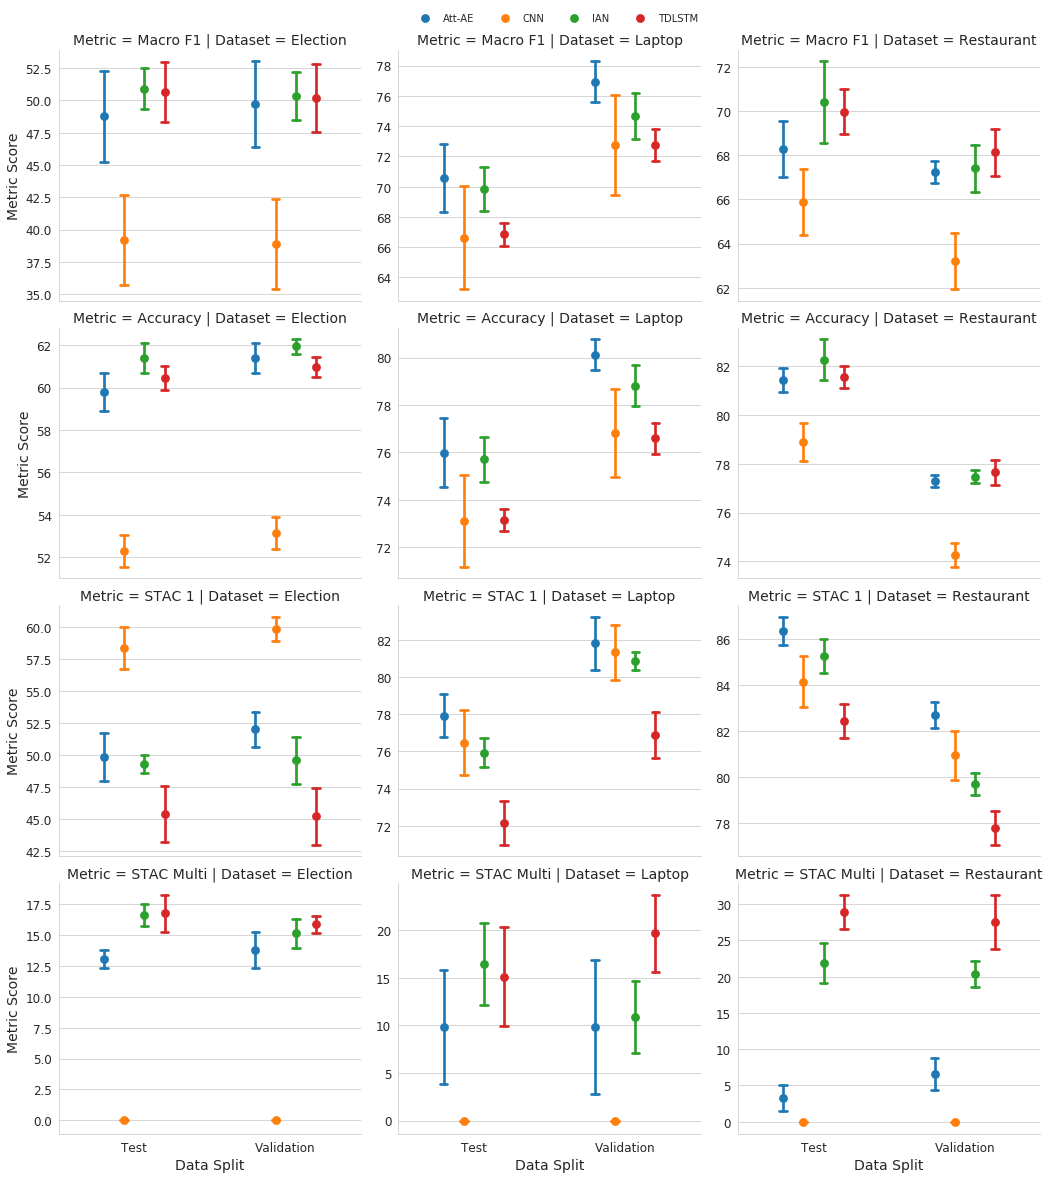

In [ ]:
import seaborn as sns
import matplotlib
matplotlib.rc('font', size=14)
plt.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

cat_plot=sns.catplot(x='Data Split', y='Metric Score',  
                     data=overall_position_plotting_results, 
                     kind='point', col='Dataset', ci='sd', join=False, capsize=.05,
                     hue='Model' ,dodge=0.4, sharey=False, row='Metric', legend=False,
                     col_order=DATASET_COLUMN_ORDER, 
                     row_order=METRIC_ORDER)
cat_plot.fig.set_size_inches(15,16)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, 
                        bbox_to_anchor=(0.3, 1))

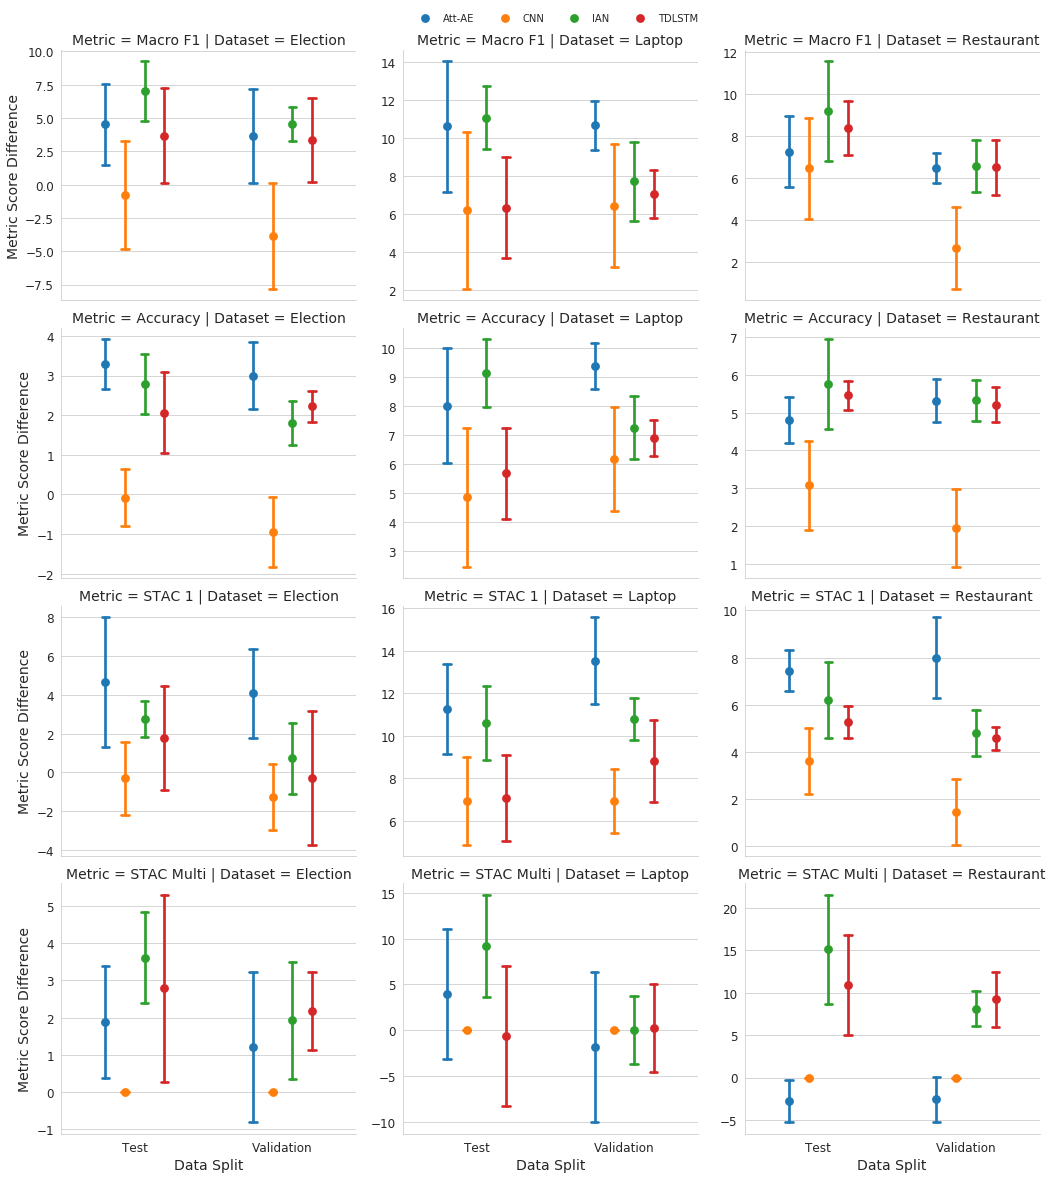

In [ ]:
metric_indexs = ['run number', 'Model', 'Dataset', 'Data Split', 'Metric']
difference_position_plotting_results = compare_results(overall_position_plotting_results, 
                                                       overall_baseline_plotting_results, 
                                                       metric_indexs, 'Metric Score')
difference_position_plotting_results['Metric Score Difference'] = difference_position_plotting_results['Metric Score']
cat_plot=sns.catplot(x='Data Split', y='Metric Score Difference',  
                     data=difference_position_plotting_results, 
                     kind='point', col='Dataset', ci='sd', join=False, capsize=.05,
                     hue='Model' ,dodge=0.4, sharey=False, row='Metric', legend=False,
                     col_order=DATASET_COLUMN_ORDER, 
                     row_order=METRIC_ORDER)
cat_plot.fig.set_size_inches(15,16)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=4, 
                        bbox_to_anchor=(0.3, 1))

In [ ]:
from collections import defaultdict
from target_extraction.analysis.util import create_subset_heatmap, metric_p_values
# Get P-values testing if position encoded models are better than their 
# non-position encoded base model
alpha = 0.05
metric_assumed_normal = [('Accuracy', True), ('STAC 1', True), 
                         ('STAC Multi', True), ('Macro F1', False)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
position_model_names = ['Att-AE-CWR', 'IAN-CWR', 'TDLSTM-CWR', 'CNN-CWR']
position_comparison_models = {'Att-AE-CWR': 'Att-AE', 'IAN-CWR': 'IAN',
                              'TDLSTM-CWR': 'TDLSTM', 'CNN-CWR': 'CNN'}
baseline_comparison_models = {'Att-AE': 'Att-AE-CWR', 'IAN': 'IAN-CWR',
                              'TDLSTM': 'TDLSTM-CWR', 'CNN': 'CNN-CWR'}
# Combine both the position and the baseline results so that they can be 
# compared for significance tests.
overall_combined_results = overall_position_results.copy(deep=True)
overall_combined_results['Model']= overall_combined_results['Model'].replace(baseline_comparison_models)
overall_combined_results = pd.concat([overall_combined_results, overall_baseline_results])

overall_p_values = {'Position': [], 'Baseline': []}
split_names = ['Test', 'Validation']
for comparison_name, p_value_list in overall_p_values.items():
  for split_name in split_names:
    split_df = overall_combined_results[overall_combined_results['Data Split']==split_name]
    for position_model_name in position_model_names:
      base_model_name = position_comparison_models[position_model_name]
      if comparison_name == 'Baseline':
        p_value_df = metric_p_values(split_df, f'{position_model_name}', 
                                    [base_model_name], dataset_names, 
                                    metric_assumed_normal)
      else:
        p_value_df = metric_p_values(split_df, base_model_name, 
                                     [f'{position_model_name}'], dataset_names, 
                                     metric_assumed_normal)
      p_value_df['Split'] = split_name
      p_value_list.append(p_value_df)
overall_p_values = {comparison_name: pd.concat(p_value_list, sort=False, ignore_index=True) 
                    for comparison_name, p_value_list in overall_p_values.items()}

/home/andrew/Envs/target_extraction/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Only compare TDSA models

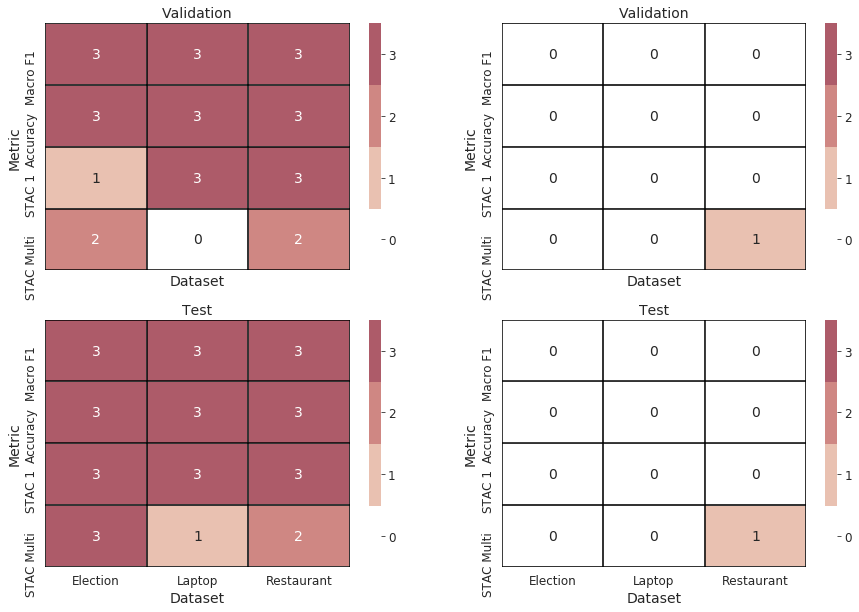

In [ ]:
v_lines = [0,1,2,3]
h_lines = [0,1,2,3,4,5]
h_map_kwargs = {'value_column': 'P-Value', 'pivot_columns': ['Dataset'], 
                'pivot_indexes': ['Metric'], 'x_label': 'Dataset', 
                'y_label': 'Metric', 'pivot_table_agg_func': p_value_count(0.05),
                'vertical_lines_index': v_lines, 
                'horizontal_lines_index': h_lines}
h_map_fig, h_map_axes = plt.subplots(2,2, figsize=(15,10), sharex=True)
for column_index, comparison_name in enumerate(['Baseline', 'Position']):
  p_value_df = overall_p_values[comparison_name]
  p_value_df = p_value_df[p_value_df['Compared Model']!='CNN']
  p_value_df = p_value_df[p_value_df['Better Model']!='CNN']
  validation_p_values = p_value_df[p_value_df['Split']=='Validation']
  test_p_values = p_value_df[p_value_df['Split']=='Test']
  h_map_axes[0][column_index] = create_p_value_heatmap(validation_p_values, **h_map_kwargs, 
                                                       row_order=METRIC_ORDER,
                                                       column_order=DATASET_COLUMN_ORDER,
                                                       ax=h_map_axes[0][column_index],
                                                       value_range=range(4),
                                                       heatmap_kwargs={'annot': True})
  h_map_axes[0][column_index].set_title('Validation')
  h_map_axes[1][column_index] = create_p_value_heatmap(test_p_values, **h_map_kwargs, 
                                                       row_order=METRIC_ORDER,
                                                       column_order=DATASET_COLUMN_ORDER,
                                                       ax=h_map_axes[1][column_index],
                                                       value_range=range(4),
                                                       heatmap_kwargs={'annot': True})
  _ = h_map_axes[1][column_index].set_title('Test')

Only compare TDSA models

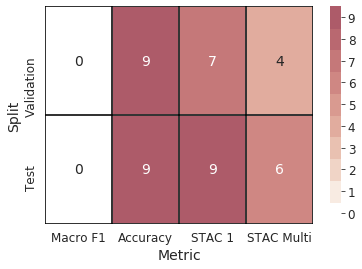

In [ ]:
from target_extraction.analysis.statistical_analysis import find_k_estimator
corrected_split_names = []
corrected_sig_models = []
corrected_metrics = []
for split_name in split_names:
  p_value_df = overall_p_values['Baseline']
  p_value_df = p_value_df[p_value_df['Compared Model']!='CNN']
  split_df = p_value_df[p_value_df['Split']==split_name]
  metrics = split_df['Metric'].unique().tolist()
  for metric in metrics:
    metric_df = split_df[split_df['Metric']==metric]
    num_sig_models = find_k_estimator(metric_df['P-Value'], 
                                      alpha=0.05, method='B')
    corrected_metrics.append(metric)
    corrected_sig_models.append(num_sig_models)
    corrected_split_names.append(split_name)
corrected_p_values_df = pd.DataFrame({'Num Sig Models': corrected_sig_models, 
                                      'Metrics': corrected_metrics, 
                                      'Split': corrected_split_names})
h_map_sig_kwargs = {'value_column': 'Num Sig Models', 'pivot_columns': ['Metrics'], 
                    'pivot_indexes': ['Split'], 'x_label': 'Metric', 
                    'y_label': 'Split', 'pivot_table_agg_func': np.sum,
                    'vertical_lines_index': [0,1,2,3,4,5,6], 
                    'horizontal_lines_index': [0,1,2]}
heatmap_kwargs = {'annot': True}
_ = create_p_value_heatmap(corrected_p_values_df, **h_map_sig_kwargs, 
                           column_order=METRIC_ORDER,
                           row_order = SPLIT_ORDER,
                           value_range=range(10),
                           heatmap_kwargs=heatmap_kwargs)

In [ ]:
# Get the position weighted and the baseline plotting results
import copy
from target_extraction.analysis.sentiment_error_analysis import ERROR_SPLIT_SUBSET_NAMES
from target_extraction.analysis.sentiment_error_analysis import subset_name_to_error_split
from target_extraction.analysis.sentiment_error_analysis import PLOT_SUBSET_ABBREVIATION
subset_names = []
subset_names = copy.deepcopy(ERROR_SPLIT_SUBSET_NAMES['DS'])
subset_names.extend(ERROR_SPLIT_SUBSET_NAMES['TSR'])

subset_plotting_results = long_format_metrics(all_results, subset_names)
subset_plotting_results['Error Split'] = subset_plotting_results.apply(lambda x: subset_name_to_error_split(x['Metric']), 1)
subset_plotting_results['Accuracy'] = subset_plotting_results['Metric Score'] * 100
subset_plotting_results = subset_plotting_results.rename(columns={'Metric': 'Error Subset'})
subset_plotting_results['Error Subset'] = subset_plotting_results.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['Error Subset']], 1)
# Drop the DS3 results for the Laptop and Restaurant datasets
laptop_ds3_filter = (subset_plotting_results['Dataset']=='Laptop') & (subset_plotting_results['Error Subset']=='DS3')
restaurant_ds3_filter = (subset_plotting_results['Dataset']=='Restaurant') & (subset_plotting_results['Error Subset']=='DS3')
subset_plotting_results = subset_plotting_results[~(laptop_ds3_filter | restaurant_ds3_filter)]

subset_position_plotting_results = filter_df(subset_plotting_results, position_column_values)
subset_position_plotting_validation_results = subset_position_plotting_results[subset_position_plotting_results['Data Split']=='Validation']
subset_position_plotting_test_results = subset_position_plotting_results[subset_position_plotting_results['Data Split']=='Test']

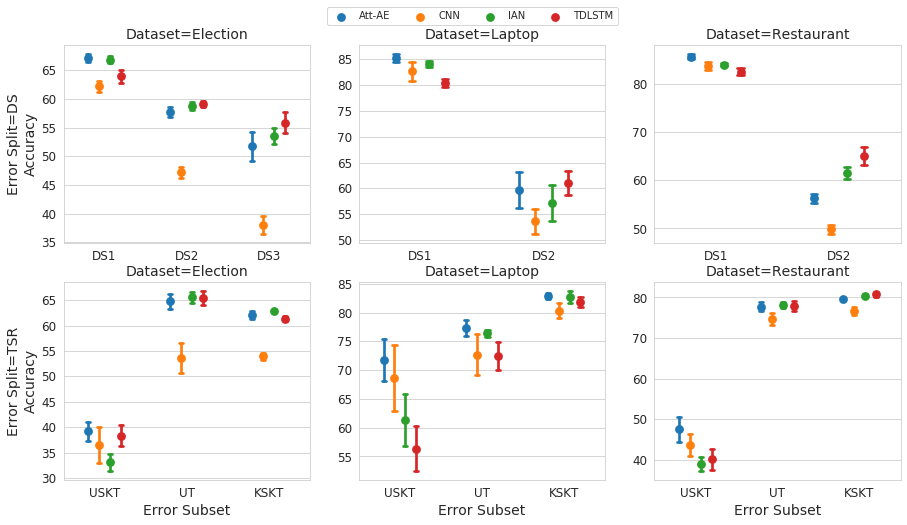

In [ ]:
from target_extraction.analysis.util import plot_error_subsets
_, _ = plot_error_subsets(subset_position_plotting_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(-0.13, 1.1))

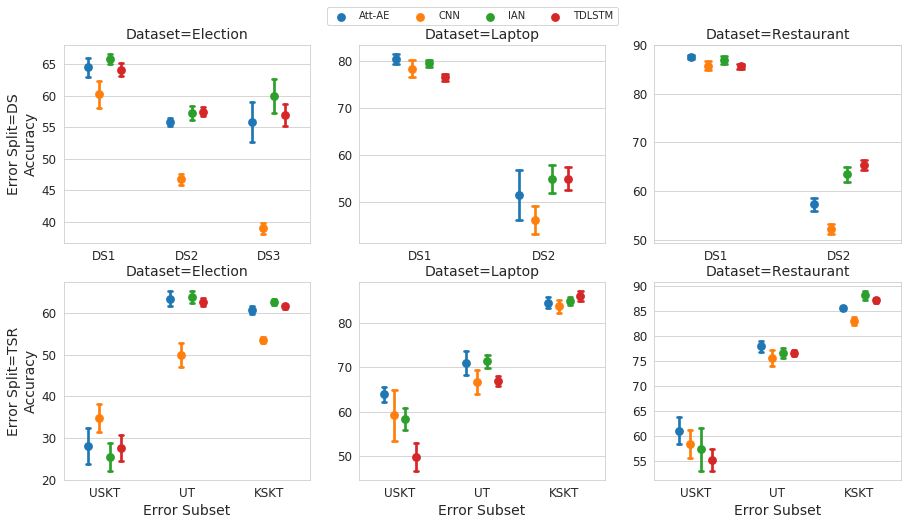

In [ ]:
_, _ = plot_error_subsets(subset_position_plotting_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(-0.13, 1.1))

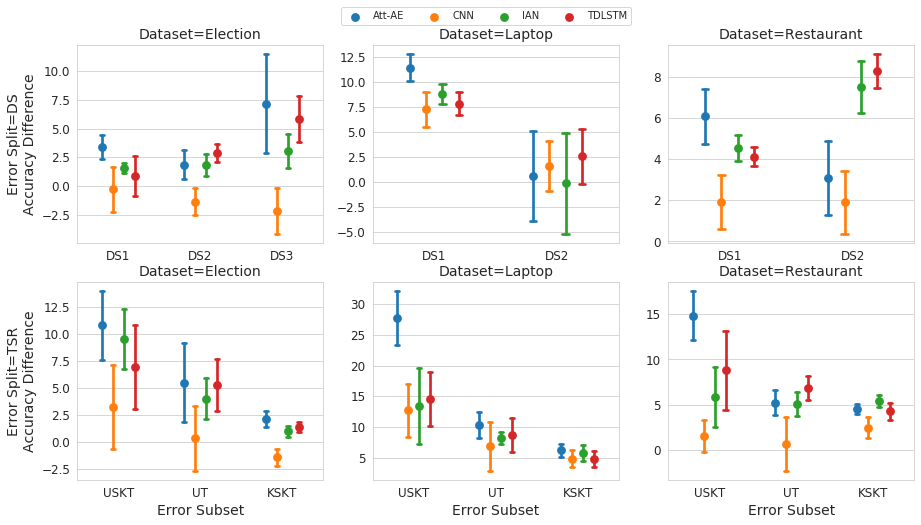

In [ ]:
subset_baseline_plotting_results = filter_df(subset_plotting_results, baseline_column_values)
metric_indexs = ['run number', 'Model', 'Dataset', 'Data Split', 'Error Split', 'Error Subset']
subset_compare_plotting_results = compare_results(subset_position_plotting_results, 
                                                  subset_baseline_plotting_results, 
                                                  metric_indexs, 'Accuracy')
subset_compare_plotting_results['Accuracy Difference'] = subset_compare_plotting_results['Accuracy']
subset_compare_plotting_validation_results = subset_compare_plotting_results[subset_compare_plotting_results['Data Split']=='Validation']
subset_compare_plotting_test_results = subset_compare_plotting_results[subset_compare_plotting_results['Data Split']=='Test']
_, _ = plot_error_subsets(subset_compare_plotting_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(-0.13, 1.1))

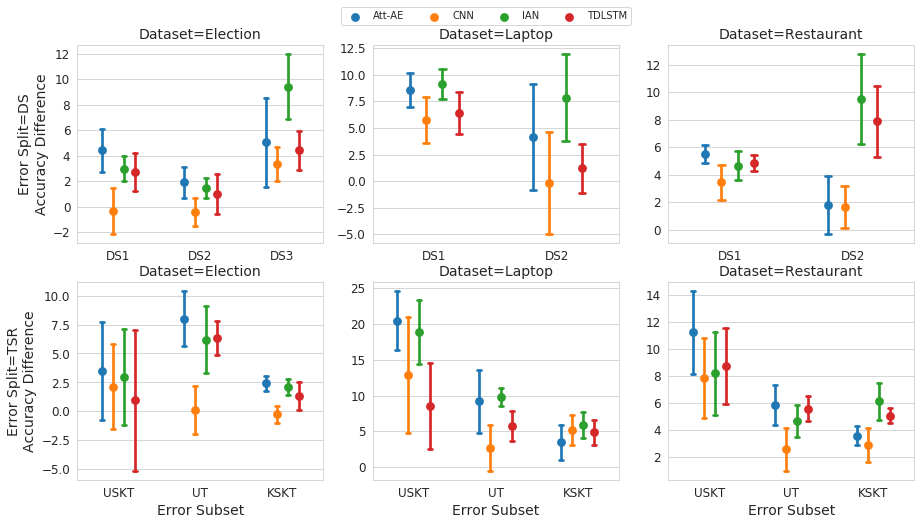

In [ ]:
_, _ = plot_error_subsets(subset_compare_plotting_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(-0.13, 1.1))

Only looking at the TDSA models:

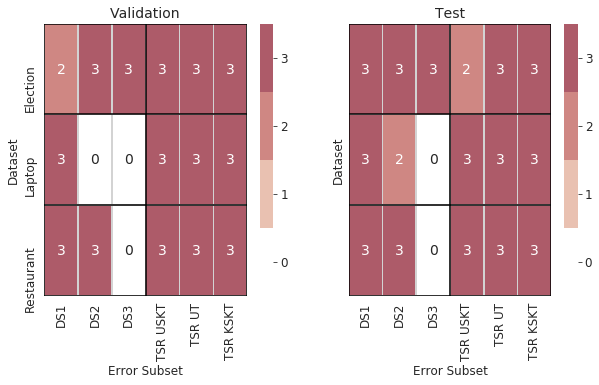

In [ ]:
subset_combined_plotting_results = subset_position_plotting_results.copy(deep=True)
subset_combined_plotting_results['Model'] = subset_combined_plotting_results['Model'].replace(baseline_comparison_models)
subset_combined_plotting_results = pd.concat([subset_combined_plotting_results, 
                                              subset_baseline_plotting_results],
                                             sort=False, ignore_index=True)
tdsa_models = ['Att-AE-CWR', 'IAN-CWR', 'TDLSTM-CWR']
error_subsets = ['DS1', 'DS2', 'DS3', 'USKT', 'UT', 'KSKT']
p_value_list = []
for split_name in split_names:
  split_df = subset_combined_plotting_results[subset_combined_plotting_results['Data Split']==split_name]
  for tdsa_model in tdsa_models:
    for error_subset in error_subsets:
      error_subset_split_df = split_df[split_df['Error Subset']==error_subset]
      base_model_name = position_comparison_models[tdsa_model]
      p_value_df = metric_p_values(error_subset_split_df, f'{tdsa_model}', 
                                   [base_model_name], dataset_names, 
                                   metric_names_assume_normals=[('Accuracy', True)])
      error_split = error_subset_split_df['Error Split'].unique()[0]
      p_value_df['Split'] = split_name
      p_value_df['Error Subset'] = error_subset
      p_value_df['Error Split'] = error_split
      p_value_list.append(p_value_df)
error_subset_p_values = pd.concat(p_value_list)
validation_error_subset_p_values = error_subset_p_values[error_subset_p_values['Split']=='Validation']
test_error_subset_p_values = error_subset_p_values[error_subset_p_values['Split']=='Test']

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0] = create_subset_heatmap(validation_error_subset_p_values, 'P-Value', 
                                p_value_count(0.05), ax=axes[0], 
                                font_label_size=12,
                                value_range=range(4),
                                heatmap_kwargs={'annot': True},
                                vertical_lines_index=[0,3,6])
axes[0].set_title('Validation')
axes[1] = create_subset_heatmap(test_error_subset_p_values, 'P-Value', 
                                p_value_count(0.05), ax=axes[1], 
                                font_label_size=12,
                                value_range=range(4),
                                heatmap_kwargs={'annot': True},
                                vertical_lines_index=[0,3,6])
_ = axes[1].set_title('Test')

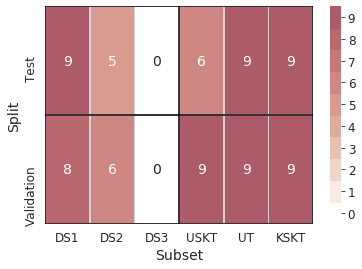

In [ ]:
corrected_subset_split_names = []
corrected_subset_sig_models = []
corrected_subsets = []
for split_name in split_names:
  split_df = error_subset_p_values[error_subset_p_values['Split']==split_name]
  for subset in error_subsets:
    subset_df = split_df[split_df['Error Subset']==subset]
    num_sig_models = find_k_estimator(subset_df['P-Value'], 
                                      alpha=0.05, method='B')
    corrected_subsets.append(subset)
    corrected_subset_sig_models.append(num_sig_models)
    corrected_subset_split_names.append(split_name)
corrected_subset_p_values_df = pd.DataFrame({'Num Sig Models': corrected_subset_sig_models, 
                                             'Subsets': corrected_subsets, 
                                             'Split': corrected_subset_split_names})
h_map_subset_kwargs = {'value_column': 'Num Sig Models', 'pivot_columns': ['Subsets'], 
                       'pivot_indexes': ['Split'], 'x_label': 'Subset', 
                       'y_label': 'Split', 'pivot_table_agg_func': np.sum,
                       'vertical_lines_index': [0,3,6], 
                       'horizontal_lines_index': range(3)}
_ = create_p_value_heatmap(corrected_subset_p_values_df, **h_map_subset_kwargs, 
                           value_range=range(10),heatmap_kwargs={'annot': True},
                           column_order=['DS1','DS2','DS3','USKT','UT','KSKT'])